In [16]:
import numpy as np, matplotlib.pyplot as plt, networkx as nx, pickle, json, gzip
import pandas as pd
%matplotlib inline

## Set parameters

N_READS: Cutoff for the min number of reads supporting a given UMI/GFP-BC pair in a particular cell

N_UMIS: Cutoff for the min number of UMIs supporting a given cell/GFP-BC pair

N_HAMMING: Cutoff for the max hamming distance to collapse two GFP-BCs

CELL_BCS_PATH: Path to a .txt file with one cell-BC per line, corresponding to rows of the gene expression counts matrix

LIB_NAMES_PATH: Path to a .txt file with one library name per line, corresponding to rows of the gene expression counts matrix



In [17]:
N_READS = 10
N_UMIS = 3
N_HAMMING = 3

# CELL_BCS_PATH = 'cell_bcs_flat.txt'
# LIB_NAMES_PATH = 'samp_id_flat.txt'

In [18]:
cell_barcodes1 = pd.read_table('Diff_3/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)
cell_barcodes2 = pd.read_table('Diff_4/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)

cell_barcodes3 = pd.read_table('Regular_1/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)
cell_barcodes4 = pd.read_table('Regular_2/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)

cell_barcodes1.loc[:, 'library'] = 'Diff_3'
cell_barcodes2.loc[:, 'library'] = 'Diff_4'
cell_barcodes3.loc[:, 'library'] = 'Regular_1'
cell_barcodes4.loc[:, 'library'] = 'Regular_2'

cell_barcodes = pd.concat([cell_barcodes1, cell_barcodes2, cell_barcodes3, cell_barcodes4])
cell_barcodes.iloc[:, 0] = list(map(lambda x:x.split('-')[0], list(cell_barcodes.iloc[:, 0].values)))

In [19]:
cell_barcodes.head()

,0,library
0,AAACCCAAGACATGCG,Diff_3
1,AAACCCAGTCCGAAAG,Diff_3
2,AAACCCATCAATCCGA,Diff_3
3,AAACCCATCGGAACTT,Diff_3
4,AAACCCATCTGCTAGA,Diff_3


In [20]:
cell_barcodes.shape

(27506, 2)

In [21]:
cell_bcs = cell_barcodes.iloc[:, 0].values
lib_names = cell_barcodes.iloc[:, 1].values
cell_barcodes.head()

,0,library
0,AAACCCAAGACATGCG,Diff_3
1,AAACCCAGTCCGAAAG,Diff_3
2,AAACCCATCAATCCGA,Diff_3
3,AAACCCATCGGAACTT,Diff_3
4,AAACCCATCTGCTAGA,Diff_3


In [22]:
cell_bcs[:10]

array(['AAACCCAAGACATGCG', 'AAACCCAGTCCGAAAG', 'AAACCCATCAATCCGA',
       'AAACCCATCGGAACTT', 'AAACCCATCTGCTAGA', 'AAACGAAAGTTTGGCT',
       'AAACGAACACGCTGCA', 'AAACGAACAGACGCTC', 'AAACGAACATCAGCTA',
       'AAACGAAGTTCCTAAG'], dtype=object)

In [23]:
lib_names[:10]

array(['Diff_3', 'Diff_3', 'Diff_3', 'Diff_3', 'Diff_3', 'Diff_3',
       'Diff_3', 'Diff_3', 'Diff_3', 'Diff_3'], dtype=object)

In [24]:
np.unique(lib_names, return_counts=True)

(array(['Diff_3', 'Diff_4', 'Regular_1', 'Regular_2'], dtype=object),
 array([ 5600,  5466, 10038,  6402]))

## Read input files

In [25]:
cell_barcodes1 = list(map(lambda x:x.split('-')[0], cell_barcodes1.iloc[:, 0].values))
cell_barcodes2 = list(map(lambda x:x.split('-')[0], cell_barcodes2.iloc[:, 0].values))

cell_barcodes3 = list(map(lambda x:x.split('-')[0], cell_barcodes3.iloc[:, 0].values))
cell_barcodes4 = list(map(lambda x:x.split('-')[0], cell_barcodes4.iloc[:, 0].values))

cell_barcodes = {'Diff_3': cell_barcodes1, 'Diff_4': cell_barcodes2,
                 'Regular_1': cell_barcodes3, 'Regular_2': cell_barcodes4}

## Load data and count reads

Read in the output of step 1 (LARRY_sorting_and_filtering.py) and count the number of reads supporting each (Sample, Cell-BC, UMI, GFP-BC) combination

In [26]:
import glob
glob.glob('*/*BC.txt.gz')

['Regular_1/Regular_1_S1_L002_BC.txt.gz',
 'Regular_1/Regular_1_S1_L004_BC.txt.gz',
 'Regular_1/Regular_1_S1_L001_BC.txt.gz',
 'Regular_1/Regular_1_S1_L003_BC.txt.gz',
 'Regular_2/Regular_2_S2_L002_BC.txt.gz',
 'Regular_2/Regular_2_S2_L003_BC.txt.gz',
 'Regular_2/Regular_2_S2_L004_BC.txt.gz',
 'Regular_2/Regular_2_S2_L001_BC.txt.gz',
 'Diff_3/Diff_3_S1_L001_BC.txt.gz',
 'Diff_3/Diff_3_S1_L002_BC.txt.gz',
 'Diff_3/Diff_3_S1_L004_BC.txt.gz',
 'Diff_3/Diff_3_S1_L003_BC.txt.gz',
 'Diff_4/Diff_4_S2_L002_BC.txt.gz',
 'Diff_4/Diff_4_S2_L003_BC.txt.gz',
 'Diff_4/Diff_4_S2_L004_BC.txt.gz',
 'Diff_4/Diff_4_S2_L001_BC.txt.gz']

In [28]:
import gzip
import os

counts = {}
for inf in glob.glob('*/*BC.txt.gz'):
    sample = os.path.dirname(inf)
    print(sample)
    f = gzip.open(inf)
    l = f.readline().decode("utf-8").strip('\n')
    current_tag = []
    i = 0
    print('Reading in all barcodes')
    while not (l == '' and len(current_tag)==0):
        i += 1
        if i % (3*10**6)==0: print('Processed '+repr(int(i/3))+' reads')
        if l == '':
            current_tag = []
        elif l[0] == '>':
            current_tag = l[1:].split(',')
        elif l != '' and len(current_tag)==3:
            current_tag.append(l)
            current_tag = tuple(current_tag)
            if not current_tag in counts: counts[current_tag] = 0
            counts[current_tag] += 1
        l = f.readline().decode("utf-8").strip('\n')
    f.close()

Regular_1
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Regular_1
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Regular_1
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Regular_1
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Regular_2
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Regular_2
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Regular_2
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Regular_2
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Diff_3
Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
P

## Filter by number of reads
Continue with analysis with (Sample, Cell-BC, UMI, GFP-BC) combinations supported by at least N_READS reads

In [29]:
len(counts.keys())

25446565

In [32]:
list(counts.keys())[:3]

[('Regular_1',
  'GCCAGTGCACGTACTA',
  'TTTGTGATTACT',
  'AAAATGAAACCAGTGCACAGGTGATCACG'),
 ('Regular_1',
  'CAGCAGCAGTCACGCC',
  'TTTGACCAAAAC',
  'CTCGTGGTACCATATCACGATTGAGGCAG'),
 ('Regular_1',
  'GCACATAAGATGGTAT',
  'CCAATCCCAGTG',
  'CACCTGTTCGCAATCTACCTTCGACTACG')]

In [31]:
sum(num_reads) # all cell barcode

90425293

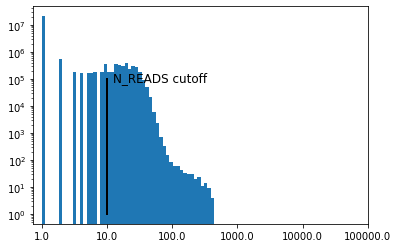

In [34]:
num_reads = [v for k,v in counts.items()]
# To specify the number of ticks on both or any single axes
plt.hist(np.log(num_reads)/np.log(10), bins=50)
plt.locator_params(axis='x', nbins=5)
#pyplot.locator_params(axis='x', nbins=10)
plt.plot([np.log(N_READS)/np.log(10),
          np.log(N_READS)/np.log(N_READS)],[1,10**5],'-k',linewidth=2)
plt.xticks(range(6),np.logspace(0,5,6))
plt.text(np.log(N_READS)/np.log(10)*1.1,10**5*.8,'N_READS cutoff', fontsize=12)
plt.yscale('log')

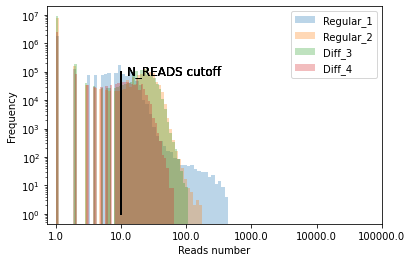

In [40]:
for condition in ['Regular_1', 'Regular_2', 'Diff_3', 'Diff_4']:
    num_reads = [v for k,v in counts.items() if k[0]==condition]
    # To specify the number of ticks on both or any single axes
    plt.hist(np.log(num_reads)/np.log(10), bins=50, alpha=0.3, label=condition)
    plt.locator_params(axis='x', nbins=5)
    #pyplot.locator_params(axis='x', nbins=10)
    plt.plot([np.log(N_READS)/np.log(10),
              np.log(N_READS)/np.log(N_READS)],[1,10**5],'-k',linewidth=2)
    plt.xticks(range(6),np.logspace(0,5,6))
    plt.text(np.log(N_READS)/np.log(10)*1.1,10**5*.8,'N_READS cutoff', fontsize=12)
    plt.yscale('log')
plt.xlabel('Reads number')    
plt.ylabel('Frequency')
plt.legend()

In [41]:
counts_filtered = {k:v for k,v in counts.items() if v >= N_READS}
print('Retaining '+repr(len(counts_filtered))+ ' out of '+repr(len(counts))+' (Sample,Cell-BC,UMI,GFP-BC) combinations')

Retaining 3032315 out of 25446565 (Sample,Cell-BC,UMI,GFP-BC) combinations


In [42]:
3032315.0 / 25446565

0.11916402076272377

## Collapse GFP-BCs by hamming distance

In [43]:
def hamming(bc1,bc2): return np.sum([x1 != x2 for x1,x2 in zip(bc1,bc2)])

all_gfp_bcs = sorted(set([k[3] for k in counts_filtered]))
good_gfp_bcs = []
bc_map = {}
for i,bc1 in enumerate(all_gfp_bcs):
    if i > 0 and i % 500 == 0: print('Mapped '+repr(i)+' out of '+repr(len(all_gfp_bcs))+' barcodes')
    mapped = False
    for bc2 in good_gfp_bcs:
        if hamming(bc1,bc2) <= N_HAMMING:
            mapped = True
            bc_map[bc1] = bc2
            break
    if not mapped:
        good_gfp_bcs.append(bc1)

print('\nCollapsed '+repr(len(bc_map))+' barcodes')
for bc in good_gfp_bcs: bc_map[bc] = bc

Mapped 500 out of 20183 barcodes
Mapped 1000 out of 20183 barcodes
Mapped 1500 out of 20183 barcodes
Mapped 2000 out of 20183 barcodes
Mapped 2500 out of 20183 barcodes
Mapped 3000 out of 20183 barcodes
Mapped 3500 out of 20183 barcodes
Mapped 4000 out of 20183 barcodes
Mapped 4500 out of 20183 barcodes
Mapped 5000 out of 20183 barcodes
Mapped 5500 out of 20183 barcodes
Mapped 6000 out of 20183 barcodes
Mapped 6500 out of 20183 barcodes
Mapped 7000 out of 20183 barcodes
Mapped 7500 out of 20183 barcodes
Mapped 8000 out of 20183 barcodes
Mapped 8500 out of 20183 barcodes
Mapped 9000 out of 20183 barcodes
Mapped 9500 out of 20183 barcodes
Mapped 10000 out of 20183 barcodes
Mapped 10500 out of 20183 barcodes
Mapped 11000 out of 20183 barcodes
Mapped 11500 out of 20183 barcodes
Mapped 12000 out of 20183 barcodes
Mapped 12500 out of 20183 barcodes
Mapped 13000 out of 20183 barcodes
Mapped 13500 out of 20183 barcodes
Mapped 14000 out of 20183 barcodes
Mapped 14500 out of 20183 barcodes
Mappe

In [44]:
len(bc_map.values())

20183

In [47]:
len(good_gfp_bcs)+2529

20183

## Filter GFP-barcodes by UMI
Index (UMI, GFP-BC) combinations to cells, then filter out BCs supported by fewer than N_UMIS UMIs

In [59]:
list(counts_filtered.keys())[:2]

[('Regular_1',
  'GCCAGTGCACGTACTA',
  'TTTGTGATTACT',
  'AAAATGAAACCAGTGCACAGGTGATCACG'),
 ('Regular_1',
  'CAGCAGCAGTCACGCC',
  'TTTGACCAAAAC',
  'CTCGTGGTACCATATCACGATTGAGGCAG')]

In [68]:
cell_data = {}
for lib,cell in zip(lib_names,cell_bcs):
    cell_data[(lib,cell)] = {}
print(lib,cell)

for lib,cell,umi,BC in counts_filtered.keys():
    if (lib,cell) in cell_data:
        if not BC in cell_data[(lib,cell)]:
            cell_data[(lib,cell)][BC] = 0
        cell_data[(lib,cell)][BC] += 1

Regular_2 TTTGTTGGTTAAGGAT


In [69]:
xaxis = 50        
BC_lists = []
for i in range(1,xaxis):
    BC_list = []
    for lib,cell in zip(lib_names,cell_bcs):
        bc_counts = cell_data[(lib,cell)]
        valid_bcs = [bc_map[k] for k,v in bc_counts.items() if v >= i]
        BC_list.append(''.join(sorted(valid_bcs)))
    BC_lists.append(BC_list)

In [70]:
len(list(cell_data.keys())), len(cell_bcs)

(27506, 27506)

In [71]:
N_UMIS

3


Final annotation has 11770 clones in 18065 cells


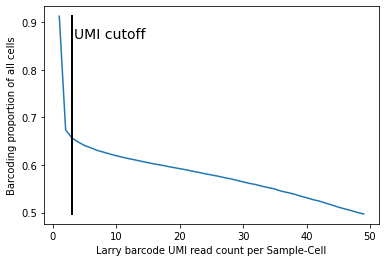

In [87]:
efficiency = np.array([len([ll for ll in l if len(ll)>0]) for l in BC_lists]) / len(cell_bcs)
plt.plot(range(1,xaxis),efficiency)
plt.plot([N_UMIS,N_UMIS], [np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
plt.text(N_UMIS*1.1, np.max(efficiency)*.95,'UMI cutoff',fontsize=14)
plt.xlabel("Larry barcode UMI read count per Sample-Cell")
plt.ylabel("Barcoding proportion of all cells")
final_BCs = BC_lists[N_UMIS-1]
print('\nFinal annotation has '+\
      repr(len(set(final_BCs)))+' clones in '+repr(len([l for l in final_BCs if len(l)>0]))+' cells')

Text(0, 0.5, 'Frequency')

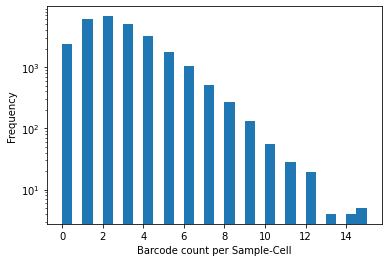

In [82]:
freq = []
for lib,cell in zip(lib_names,cell_bcs):
    freq.append(len(cell_data[(lib,cell)].keys()))
plt.hist(freq, bins=30)
plt.yscale('log')
plt.xlabel("Barcode count per Sample-Cell")
plt.ylabel("Frequency")    

Text(0, 0.5, 'Frequency')

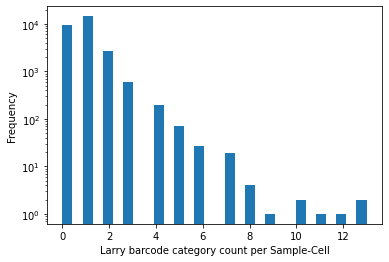

In [88]:
freq = []
for lib,cell in zip(lib_names,cell_bcs):
    freq.append(len([cell_data[(lib,cell)][key] for key in cell_data[(lib,cell)].keys() if cell_data[(lib,cell)][key]>=N_UMIS]))
N_UMIS    

plt.hist(freq, bins=30)
plt.yscale('log')
plt.xlabel("Larry barcode category count per Sample-Cell")
plt.ylabel("Frequency")

In [44]:
len(BC_list), len(BC_lists)

(27506, 49)

## Output clonal anotations
There are three output files: 
- clone_mat.csv
- clone_mat.npy
- barcode_list.txt

The two clone_mat files store a binary matrix where rows are cells and columns are clones. A "1" at entry (i,j) indicates that cell i belongs to clone j. The barcode_list file stores the barcode for each cell. Two barcode strings separated by an underscore indicates that the cell contains multiple barcodes. An empty line implies no barcode for that cell.

Text(0, 0.5, 'Frequency')

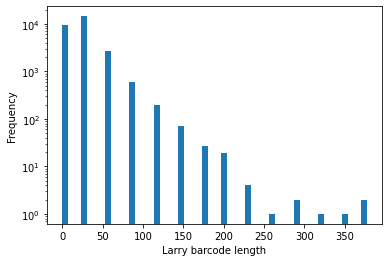

In [94]:
plt.hist(list(map(lambda x:len(x), final_BCs)), bins=50)
plt.yscale('log')
plt.xlabel("Larry barcode length")
plt.ylabel("Frequency")

In [95]:
len('CACCTGTTCGCAATCTACCTTCGACTACG')

29

In [98]:
len(final_BCs), len(set(final_BCs))

(27506, 11770)

In [99]:
len([l for l in final_BCs if l!=''])

18065

In [100]:
len(set(sorted([bc for bc in final_BCs if bc != ''])))

11769

In [101]:
BC_set = sorted(set([bc for bc in final_BCs if bc != '']))
len(BC_set)

11769

In [103]:
clone_mat = np.zeros((len(final_BCs),len(BC_set))) # (cell, LarryBC)
for i, bc in enumerate(final_BCs):
    if bc != '':
        j = BC_set.index(bc)
        clone_mat[i,j] = 1
clone_mat = np.array(clone_mat,dtype=int)

In [104]:
clone_mat.shape, type(BC_set)

((27506, 11769), list)

In [123]:
(clone_mat.sum(axis=0) > 1).sum()

3689

Text(0, 0.5, 'Larry barcode frequency')

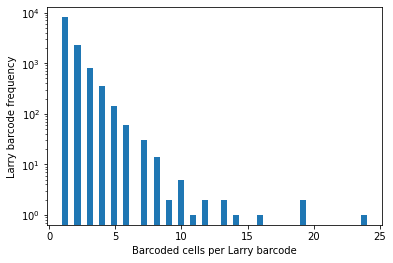

In [108]:
plt.hist(clone_mat.sum(axis=0), bins=50)
plt.yscale('log')
plt.xlabel("Barcoded cells per Larry barcode")
plt.ylabel("Larry barcode frequency")

In [109]:
np.savetxt('RD_larry2_clone_mat_condition_specific2.csv',clone_mat,delimiter=',',fmt='%i') ## clone matrix
# np.save('RD_larry2_clone_mat_condition_specific2.npy',clone_mat)
open('RD_larry2barcode_cell_list_condition_specific2.txt','w').write('\n'.join(final_BCs))
open('RD_larry2barcode_list_condition_specific2.txt','w').write('\n'.join(list(BC_set))) ## use this as larry barcodes

470896

In [113]:
cell_barcodes1 = pd.read_table('Diff_3/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)
cell_barcodes2 = pd.read_table('Diff_4/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)

cell_barcodes3 = pd.read_table('Regular_1/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)
cell_barcodes4 = pd.read_table('Regular_2/outs/filtered_feature_bc_matrix/barcodes.tsv.gz',
                               header=None)

cell_barcodes1.loc[:, 'library'] = 'Diff_3'
cell_barcodes2.loc[:, 'library'] = 'Diff_4'
cell_barcodes3.loc[:, 'library'] = 'Regular_1'
cell_barcodes4.loc[:, 'library'] = 'Regular_2'

cell_barcodes = pd.concat([cell_barcodes1, cell_barcodes2, cell_barcodes3, cell_barcodes4])
cell_barcodes.iloc[:, 0] = list(map(lambda x:x.split('-')[0], list(cell_barcodes.iloc[:, 0].values)))

In [116]:
cell_barcodes.shape

(27506, 2)

In [119]:
cell_barcodes.head()

,0,library
0,AAACCCAAGACATGCG,Diff_3
1,AAACCCAGTCCGAAAG,Diff_3
2,AAACCCATCAATCCGA,Diff_3
3,AAACCCATCGGAACTT,Diff_3
4,AAACCCATCTGCTAGA,Diff_3


In [120]:
cell_barcodes.to_csv('RD_cellbarcode.txt')

In [121]:
!wc -l RD_cellbarcode.txt

27507 RD_cellbarcode.txt
